<a href="https://colab.research.google.com/github/fgcneto/regressao-linear-de-efeitos-mistos/blob/main/Modelos_lineares_de_efeitos_mistos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Um modelo linear de efeitos mistos é uma abordagem simples para modelar relacionamentos lineares estruturados (Harville, 1997; Laird e Ware, 1982). Cada ponto de dados consiste em entradas de tipos variados — categorizados em grupos — e uma saída de valor real. Um modelo linear de efeitos mistos é um modelo hierárquico: ele compartilha força estatística entre grupos para melhorar as inferências sobre qualquer ponto de dados individual.

Neste tutorial, demonstramos modelos de efeitos mistos lineares com um exemplo do mundo real no TensorFlow Probability. Usaremos os módulos JointDistributionCoroutine e Markov Chain Monte Carlo (tfp.mcmc).

### Dependencias e pré requisitos


In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float64

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

Precisamos nos certificar de que estamos usando uma GPU para esta demonstração.

O snippet a seguir verificará se temos acesso a uma GPU.

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

## Obtendo os dados

In [3]:
def load_insteval():
  """Loads the InstEval data set.

  It contains 73,421 university lecture evaluations by students at ETH
  Zurich with a total of 2,972 students, 2,160 professors and
  lecturers, and several student, lecture, and lecturer attributes.
  Implementation is built from the `observations` Python package.

  Returns:
    Tuple of np.ndarray `x_train` with 73,421 rows and 7 columns and
    dictionary `metadata` of column headers (feature names).
  """
  url = ('https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/'
         'lme4/InstEval.csv')
  with requests.Session() as s:
    download = s.get(url)
    f = download.content.decode().splitlines()

  iterator = csv.reader(f)
  columns = next(iterator)[1:]
  x_train = np.array([row[1:] for row in iterator], dtype=np.int)
  metadata = {'columns': columns}
  return x_train, metadata

Carregamos e pré-processamos o conjunto de dados. Retemos 20% dos dados para que possamos avaliar nosso modelo ajustado em pontos de dados não vistos. Abaixo visualizamos as primeiras linhas.

In [4]:
data, metadata = load_insteval()
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s': 'students',
                            'd': 'instructors',
                            'dept': 'departments',
                            'y': 'ratings'})
data['students'] -= 1  # start index by 0
# Remap categories to start from 0 and end at max(category).
data['instructors'] = data['instructors'].astype('category').cat.codes
data['departments'] = data['departments'].astype('category').cat.codes

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,students,instructors,studage,lectage,service,departments,ratings
37930,1543,456,6,6,0,9,1
206,26,30,2,1,1,10,3
9475,355,938,4,4,1,10,1
18203,721,774,4,3,0,4,3
5818,211,512,8,5,0,9,5


Configuramos o conjunto de dados em termos de um dicionário de entradas `features` e uma saída `labels` correspondente às avaliações.

In [5]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {
    k: get_value(train, key=k, dtype=np.int32)
    for k in ['students', 'instructors', 'departments', 'service']}
labels_train = get_value(train, key='ratings', dtype=np.float32)

features_test = {k: get_value(test, key=k, dtype=np.int32)
                 for k in ['students', 'instructors', 'departments', 'service']}
labels_test = get_value(test, key='ratings', dtype=np.float32)

In [6]:
num_students = max(features_train['students']) + 1
num_instructors = max(features_train['instructors']) + 1
num_departments = max(features_train['departments']) + 1
num_observations = train.shape[0]

print("Número de Estudantes:", num_students)
print("Número de Instrutores:", num_instructors)
print("Número de Departamentos:", num_departments)
print("Número de Observações:", num_observations)

Número de Estudantes: 2972
Número de Instrutores: 1128
Número de Departamentos: 14
Número de Observações: 58737


## Modelo

Um modelo linear típico assume independência, onde qualquer par de pontos de dados tem uma relação linear constante. No conjunto de dados `InstEval`, as observações surgem em grupos, cada um dos quais pode ter inclinações e interceptações variadas. Modelos lineares de efeitos mistos, também conhecidos como modelos lineares hierárquicos ou modelos lineares multiníveis, capturam esse fenômeno (Gelman & Hill, 2006).

Exemplos desse fenômeno incluem:

+ __Estudantes__. As observações de um aluno não são independentes: alguns alunos podem sistematicamente dar notas baixas (ou altas) às aulas.
+ __Instrutores__. As observações de um instrutor não são independentes: esperamos que bons professores geralmente tenham boas avaliações e professores ruins geralmente tenham avaliações ruins.
+ __Departamentos__. As observações de um departamento não são independentes: alguns departamentos podem geralmente ter material seco ou classificação mais rigorosa e, portanto, ser classificados mais abaixo do que outros.

Neste tutorial, postulamos os seguintes efeitos:

Efeitos fixos: serviço. service é uma covariável binária correspondente a se o curso pertence ao departamento principal do instrutor. Não importa quantos dados adicionais coletamos, eles só podem assumir os valores 0 e 1 .
Efeitos aleatórios: alunos, instrutores e departamentos. Dadas mais observações da população de classificações de avaliação do curso, podemos estar olhando para novos alunos, professores ou departamentos.
Na sintaxe do pacote lme4 do R (Bates et al., 2015), o modelo pode ser resumido como

avaliações ~ serviço + (1|alunos) + (1|instrutores) + (1|departamentos) + 1
onde x denota um efeito fixo, (1|x) denota um efeito aleatório para x e 1 denota um termo de interceptação.

Implementamos este modelo abaixo como uma JointDistribution. Para ter um melhor suporte para rastreamento de parâmetros (por exemplo, queremos rastrear todas as tf.Variable em model.trainable_variables), implementamos o modelo de modelo como tf.Module.

In [7]:
class LinearMixedEffectModel(tf.Module):
  def __init__(self):
    # Set up fixed effects and other parameters.
    # These are free parameters to be optimized in E-steps
    self._intercept = tf.Variable(0., name="intercept")            # alpha in eq
    self._effect_service = tf.Variable(0., name="effect_service")  #  beta in eq
    self._stddev_students = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_students")            # sigma in eq
    self._stddev_instructors = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_instructors")         # sigma in eq
    self._stddev_departments = tfp.util.TransformedVariable(
        1., bijector=tfb.Exp(), name="stddev_departments")         # sigma in eq

  def __call__(self, features):
    model = tfd.JointDistributionSequential([
      # Set up random effects.
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(num_students),
          scale_identity_multiplier=self._stddev_students),
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(num_instructors),
          scale_identity_multiplier=self._stddev_instructors),
      tfd.MultivariateNormalDiag(
          loc=tf.zeros(num_departments),
          scale_identity_multiplier=self._stddev_departments),
      # This is the likelihood for the observed.
      lambda effect_departments, effect_instructors, effect_students: tfd.Independent(
          tfd.Normal(
              loc=(self._effect_service * features["service"] +
                  tf.gather(effect_students, features["students"], axis=-1) +
                  tf.gather(effect_instructors, features["instructors"], axis=-1) +
                  tf.gather(effect_departments, features["departments"], axis=-1) +
                  self._intercept),
              scale=1.),
              reinterpreted_batch_ndims=1)
    ])

    # To enable tracking of the trainable variables via the created distribution,
    # we attach a reference to `self`. Since all TFP objects sub-class
    # `tf.Module`, this means that the following is possible:
    # LinearMixedEffectModel()(features_train).trainable_variables
    # ==> tuple of all tf.Variables created by LinearMixedEffectModel.
    model._to_track = self
    return model

lmm_jointdist = LinearMixedEffectModel()
# Conditioned on feature/predictors from the training data
lmm_train = lmm_jointdist(features_train)

In [8]:
lmm_train.trainable_variables

(<tf.Variable 'stddev_students:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_instructors:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_departments:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'effect_service:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'intercept:0' shape=() dtype=float32, numpy=0.0>)

Como um programa gráfico probabilístico, também podemos visualizar a estrutura do modelo em termos de seu gráfico computacional. Esse gráfico codifica o fluxo de dados entre as variáveis aleatórias do programa, explicitando seus relacionamentos em termos de um modelo gráfico (Jordan, 2003).

Como uma ferramenta estatística, podemos olhar para o gráfico para ver melhor, por exemplo, que intercept e effect_service são condicionalmente dependentes de determinadas avaliações; isso pode ser mais difícil de ver no código-fonte se o programa for escrito com classes, referências cruzadas entre módulos e/ou sub-rotinas. Como uma ferramenta computacional, também podemos observar que as variáveis latentes fluem para a variável de classificação por meio de tf.gather ops. Isso pode ser um gargalo em certos aceleradores de hardware se a indexação de tensores for cara; a visualização do gráfico torna isso facilmente aparente.


In [9]:
lmm_train.resolve_graph()

(('effect_students', ()),
 ('effect_instructors', ()),
 ('effect_departments', ()),
 ('x', ('effect_departments', 'effect_instructors', 'effect_students')))

## Estimativa de Parâmetros

Dados dados, o objetivo da inferência é ajustar a inclinação $\beta$ dos efeitos fixos do modelo, interceptar $\alpha$ e o parâmetro do componente de variância $\sigma^2$. O princípio da máxima verossimilhança formaliza essa tarefa como

$$
\max_{\beta, \alpha, \sigma}~\log p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}; \beta, \alpha, \sigma) = \max_{\ beta, \alpha, \sigma}~\log \int p(\eta; \sigma) ~p(\mathbf{y}\mid \mathbf{X}, \mathbf{Z}, \eta; \beta, \ alfa)~d\eta.
$$

Nesta atividade, usamos o algoritmo Monte Carlo EM para maximizar essa densidade marginal (Dempster et al., 1977; Wei e Tanner, 1990).¹ Realizamos a cadeia de Markov Monte Carlo para calcular a expectativa da verossimilhança condicional em relação à efeitos aleatórios ("E-step"), e realizamos a descida do gradiente para maximizar a expectativa em relação aos parâmetros ("M-step"):

+ Para o passo E, configuramos o Hamiltoniano Monte Carlo (HMC). Ele pega um estado atual — os efeitos do aluno, instrutor e departamento — e retorna um novo estado. Atribuímos o novo estado às variáveis ​​do TensorFlow, que denotam o estado da cadeia HMC.

+ Para o passo M, usamos a amostra posterior do HMC para calcular uma estimativa imparcial da verossimilhança marginal até uma constante. Em seguida, aplicamos seu gradiente em relação aos parâmetros de interesse. Isso produz um passo descendente estocástico imparcial na probabilidade marginal. Implementamos com o otimizador Adam TensorFlow e minimizamos o negativo da marginal.

In [10]:
target_log_prob_fn = lambda *x: lmm_train.log_prob(x + (labels_train,))
trainable_variables = lmm_train.trainable_variables
current_state = lmm_train.sample()[:-1]

In [11]:
# For debugging
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=-489781.1>

In [12]:
# Set up E-step (MCMC).
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.015,
    num_leapfrog_steps=3)
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False, jit_compile=True)
def one_e_step(current_state, kernel_results):
  next_state, next_kernel_results = hmc.one_step(
      current_state=current_state,
      previous_kernel_results=kernel_results)
  return next_state, next_kernel_results

optimizer = tf.optimizers.Adam(learning_rate=.01)

# Set up M-step (gradient descent).
@tf.function(autograph=False, jit_compile=True)
def one_m_step(current_state):
  with tf.GradientTape() as tape:
    loss = -target_log_prob_fn(*current_state)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

Realizamos um estágio de aquecimento, que executa uma cadeia MCMC por várias iterações para que o treinamento possa ser inicializado dentro da massa de probabilidade posterior. Em seguida, executamos um loop de treinamento. Ele executa conjuntamente as etapas E e M e registra os valores durante o treinamento.

In [13]:
num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

In [14]:
# Run warm-up stage.
for t in range(num_warmup_iters):
  current_state, kernel_results = one_e_step(current_state, kernel_results)
  num_accepted += kernel_results.is_accepted.numpy()
  if t % 500 == 0 or t == num_warmup_iters - 1:
    print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(
        t, num_accepted / (t + 1)))

num_accepted = 0  # reset acceptance rate counter

# Run training.
for t in range(num_iters):
  # run 5 MCMC iterations before every joint EM update
  for _ in range(5):
    current_state, kernel_results = one_e_step(current_state, kernel_results)
  loss = one_m_step(current_state)
  effect_students_samples[t, :] = current_state[0].numpy()
  effect_instructors_samples[t, :] = current_state[1].numpy()
  effect_departments_samples[t, :] = current_state[2].numpy()
  num_accepted += kernel_results.is_accepted.numpy()
  loss_history[t] = loss.numpy()
  if t % 500 == 0 or t == num_iters - 1:
    print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(
        t, num_accepted / (t + 1), loss_history[t]))

Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.766
Warm-Up Iteration: 999 Acceptance Rate: 0.727
Iteration:    0 Acceptance Rate: 1.000 Loss: 98232.398
Iteration:  500 Acceptance Rate: 0.661 Loss: 96034.547
Iteration: 1000 Acceptance Rate: 0.649 Loss: 95929.461
Iteration: 1499 Acceptance Rate: 0.661 Loss: 96036.047


In [15]:
@tf.function(autograph=False, jit_compile=True)
def run_k_e_steps(k, current_state, kernel_results):
  _, next_state, next_kernel_results = tf.while_loop(
      cond=lambda i, state, pkr: i < k,
      body=lambda i, state, pkr: (i+1, *one_e_step(state, pkr)),
      loop_vars=(tf.constant(0), current_state, kernel_results)
  )
  return next_state, next_kernel_results

Para verificar se o treinamento foi sensato, verificamos que a função de perda realmente tende a convergir ao longo das iterações de treinamento.

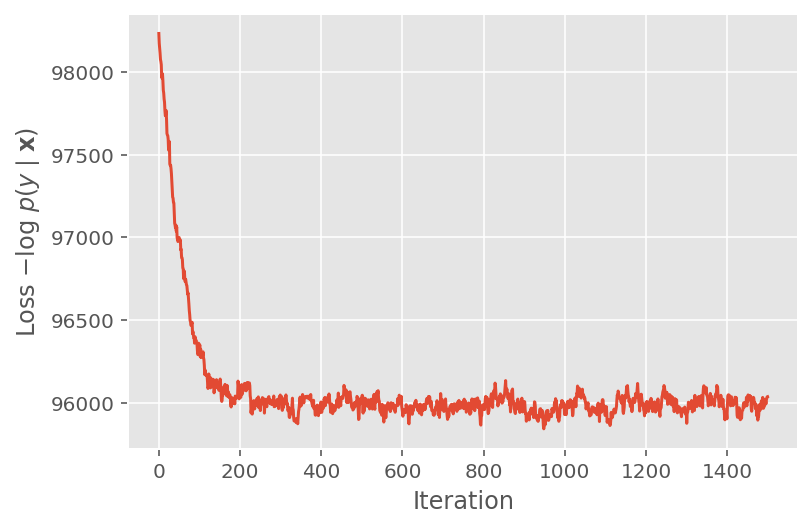

In [16]:
plt.plot(loss_history)
plt.ylabel(r'Loss $-\log$ $p(y\mid\mathbf{x})$')
plt.xlabel('Iteration')
plt.show()

Também usamos um trace plot, que mostra a trajetória do algoritmo de Monte Carlo da cadeia de Markov através de dimensões latentes específicas. Abaixo, vemos que os efeitos específicos do instrutor realmente mudam significativamente de seu estado inicial e exploram o espaço de estado. O gráfico de rastreamento também indica que os efeitos diferem entre os instrutores, mas com comportamento de mistura semelhante.

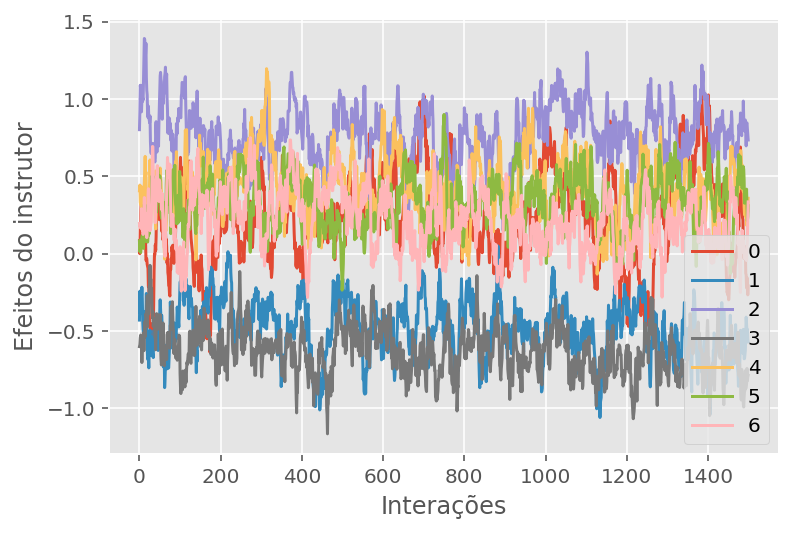

In [18]:
for i in range(7):
  plt.plot(effect_instructors_samples[:, i])

plt.legend([i for i in range(7)], loc='lower right')
plt.ylabel('Efeitos do instrutor')
plt.xlabel('Interações')
plt.show()

## Critica

Acima, ajustamos o modelo. Agora procuramos criticar seu ajuste usando dados, o que nos permite explorar e entender melhor o modelo. Uma dessas técnicas é um gráfico residual, que representa a diferença entre as previsões do modelo e a verdade básica para cada ponto de dados. Se o modelo estivesse correto, então sua diferença deveria ser distribuída normalmente; quaisquer desvios desse padrão no gráfico indicam desajuste do modelo.

Construímos o gráfico residual formando primeiro a distribuição preditiva posterior sobre as avaliações, que substitui a distribuição anterior nos efeitos aleatórios por seus dados de treinamento fornecidos posteriormente. Em particular, executamos o modelo adiante e interceptamos sua dependência de efeitos aleatórios anteriores com suas médias posteriores inferidas.²

In [19]:
lmm_test = lmm_jointdist(features_test)

[
    effect_students_mean,
    effect_instructors_mean,
    effect_departments_mean,
] = [
     np.mean(x, axis=0).astype(np.float32) for x in [
       effect_students_samples,
       effect_instructors_samples,
       effect_departments_samples
       ]
]

# Get the posterior predictive distribution
(*posterior_conditionals, ratings_posterior), _ = lmm_test.sample_distributions(
    value=(
        effect_students_mean,
        effect_instructors_mean,
        effect_departments_mean,
))

ratings_prediction = ratings_posterior.mean()

Após a inspeção visual, os resíduos parecem ter uma distribuição normal-padrão. No entanto, o ajuste não é perfeito: há massa de probabilidade maior nas caudas do que uma distribuição normal, o que indica que o modelo pode melhorar seu ajuste relaxando suas suposições de normalidade.

Em particular, embora seja mais comum usar uma distribuição normal para modelar classificações no conjunto de dados InstEval, uma análise mais detalhada dos dados revela que as classificações de avaliação do curso são, na verdade, valores ordinais de 1 a 5. Isso sugere que deveríamos usar uma distribuição ordinal, ou mesmo categórica se tivermos dados suficientes para descartar a ordenação relativa. Esta é uma alteração de uma linha no modelo acima; o mesmo código de inferência é aplicável.

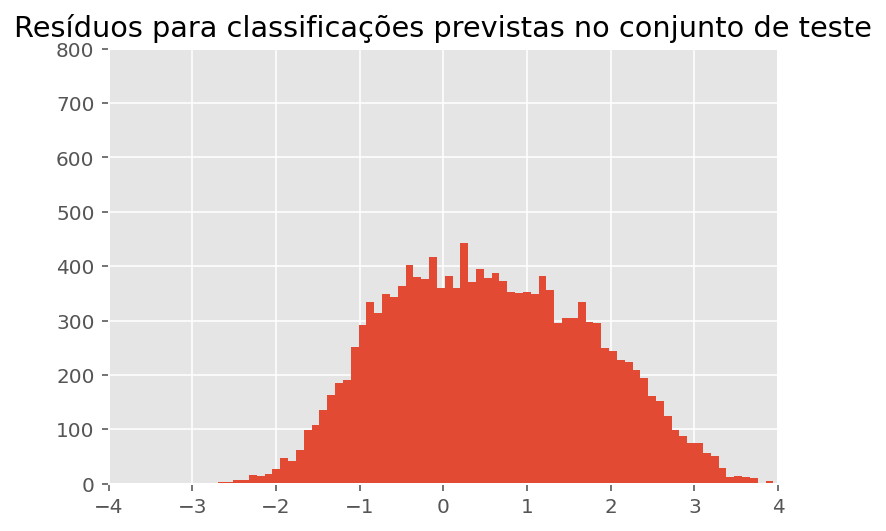

In [21]:
plt.title("Resíduos para classificações previstas no conjunto de teste")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(ratings_prediction - labels_test, 75)
plt.show()

Para explorar como o modelo faz previsões individuais, examinamos o histograma de efeitos para alunos, instrutores e departamentos. Isso nos permite entender como os elementos individuais no vetor de recursos de um ponto de dados tendem a influenciar o resultado.

Não surpreendentemente, vemos abaixo que cada aluno normalmente tem pouco efeito na classificação de avaliação de um instrutor. Curiosamente, vemos que o departamento ao qual um instrutor pertence tem um grande efeito.

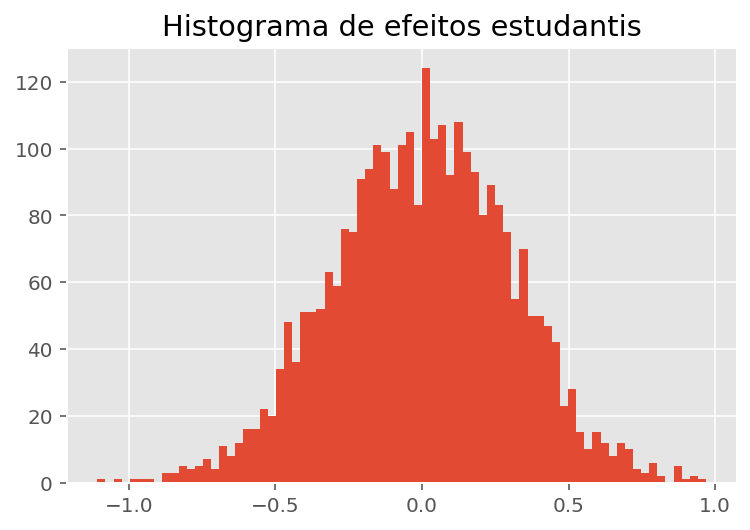

In [22]:
plt.title("Histograma de efeitos estudantis")
plt.hist(effect_students_mean, 75)
plt.show()

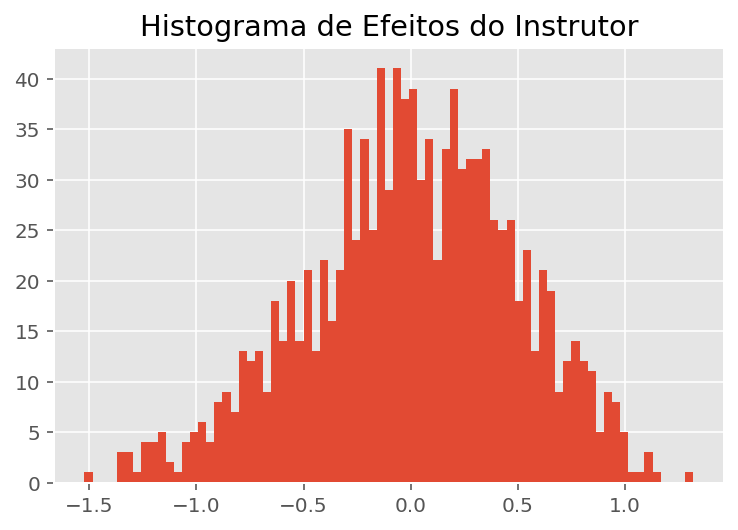

In [23]:
plt.title("Histograma de Efeitos do Instrutor")
plt.hist(effect_instructors_mean, 75)
plt.show()

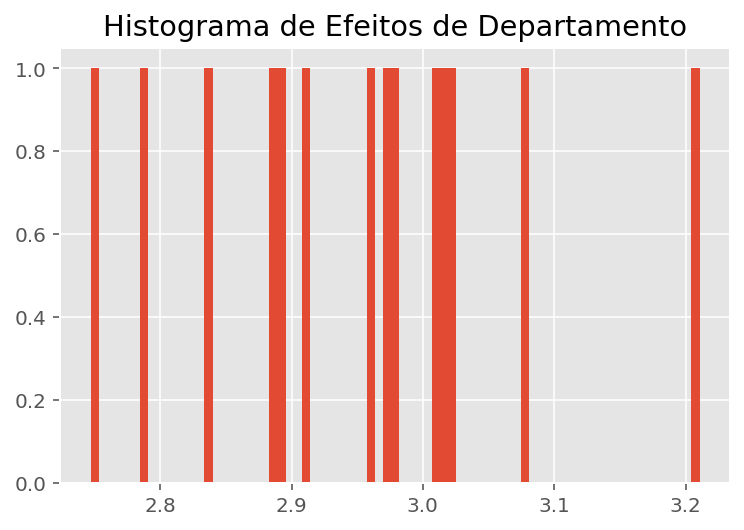

In [24]:
plt.title("Histograma de Efeitos de Departamento")
plt.hist(effect_departments_mean, 75)
plt.show()

## Finalizando

¹ Os modelos lineares de efeitos mistos são um caso especial em que podemos calcular analiticamente sua densidade marginal. Para os fins dest atividade, demonstramos Monte Carlo EM, que se aplica mais prontamente a densidades marginais não analíticas, como se a probabilidade fosse estendida para ser categórica em vez de normal.

² Para simplificar, formamos a média da distribuição preditiva usando apenas uma passagem direta do modelo. Isso é feito por condicionamento na média posterior e é válido para modelos lineares de efeitos mistos. No entanto, isso não é válido em geral: a média da distribuição preditiva posterior é tipicamente intratável e requer a obtenção da média empírica em várias passagens diretas do modelo com amostras posteriores.

## Agradecimentos

Este tutorial foi originalmente escrito em Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/linear_mixed_effects_models.ipynb)). Agradecemos a todos os colaboradores que escreveram e revisaram essa versão.

## References

1. Douglas Bates and Martin Machler and Ben Bolker and Steve Walker. Fitting Linear Mixed-Effects Models Using lme4. _Journal of Statistical Software_, 67(1):1-48, 2015.

2. Arthur P. Dempster, Nan M. Laird, and Donald B. Rubin. Maximum likelihood from incomplete data via the EM algorithm. _Journal of the Royal Statistical Society, Series B (Methodological)_, 1-38, 1977.

3. Andrew Gelman and Jennifer Hill. _Data analysis using regression and multilevel/hierarchical models._ Cambridge University Press, 2006.

4. David A. Harville. Maximum likelihood approaches to variance component estimation and to related problems. _Journal of the American Statistical Association_, 72(358):320-338, 1977.

5. Michael I. Jordan. An Introduction to Graphical Models. Technical Report, 2003.

6. Nan M. Laird and James Ware. Random-effects models for longitudinal data. _Biometrics_, 963-974, 1982.

7. Greg Wei and Martin A. Tanner. A Monte Carlo implementation of the EM algorithm and the poor man's data augmentation algorithms. _Journal of the American Statistical Association_, 699-704, 1990.